# `DETR` : End-to-End Object Detection with Transformers(ECCV 2020)
  - `DE`tection `TR`ansformer

---

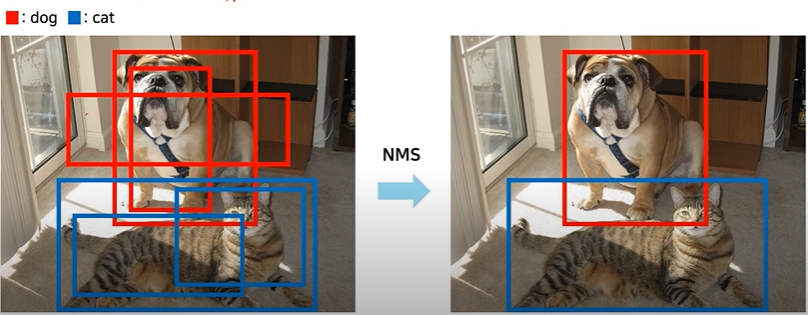

- 기존 객체 탐지
  - 많은 prior knoledge 요구
    - prior knoledge?
      - 이를테면, 탐지를 하고자하는 이미지들이 기차와 같은 긴 형태의 물체들이 많다면 bounding box를 길게 설정하여 탐지하고자 하는 그 대상에 대한 사전 지식을 사용하는 것
      - 이런식으로 bounding box의 형태, 혹은 bounding box가 겹칠 때 처리 방법들을 미리 정의해주어야 했음. 그래야 높은 성능과 각각의 instance들을 성공적으로 분류할 수 있었음
      - 흔히 NMS와 같은 기법이 하나의 이미지가 주어졌을 때 여러 개의 bounding box를 그리고, neural network가 여러 개의 이미지가 존재할법한 그런 위치를 찾아서 각각 다 classification을 진행했다면 중복되는 부분이 많이 생길텐데 이런 것들을 압축을 하여 불필요한 box들은 제거하여 각 instance 마다 한 개의 bounding box만 나올 수 있도록 압축하는 기법을 NMS라 하였음
      - 이런 기법은 bounding box를 어떤 형태로 그릴지, 압축할 때 thresholds나 hyper parameter를 어떤식으로 설정할지 세밀한 조정이 필요했고 이는 복잡한 architecture를 만들었음

$\to$ 간단한 *architecture*가 요구되었음
  - 1) 이분 매칭 함수 이용
    - set prediction problem을 직접적으로 해결
    - 객체를 탐지하는 이슈는 set prediction problem이라 할 수 있음
    - 여기서 set -> 수학적 개념인 `집합`임
      - 중복되는 원소가 없고 순서가 무관한 특성
      - 객체를 탐지함에 있어서 개를 나타내는 bounding box의 위치와 고양이를 나타내는 bounding box의 위치 순서는 상관이 없을 것
      - 즉 이런 특성을 위해 이전에는 NMS등을 이용해 resion proposal을 통해 각각 많이 제안하고 겹치는 거 제거하는 등 이러한 간접적인 일련의 과정이 필요했는데
      - 이런 set prediction problem을 직접적으로 해결할 수 있을까?에 대한 해결책이 됨
      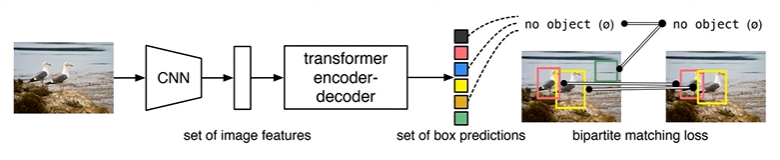
      - set of box predictions 부분에서 전체 나오는 output dimension을 N으로 고정함
        - ? 전체 N개만큼만 이미지에 object instance가 존재할 수 있을 거라 고정한다면, 이제부터는 이분매칭을 통해 직접적으로 해결할 수 있게되는 것
        - ? 무슨 말 ?
          - 예를 들어, 전체 이미지에 6개까지만 object instance가 존재할 수 있다고 가정을 해보자
          - 학습과정에서 이분매칭을 수행함으로써 인스턴스가 중복되지 않도록 유도함 
          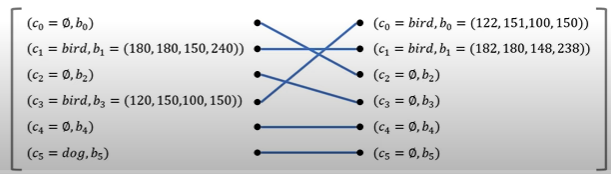
          - 첫번째 예측 결과 : nothing
          - 두번째 예측 결과 : 새가 있으며 $b_1$이라는 위치(중심x,중심y,너비,높이)
          - 세번째 예측 결과 : nothing
          - 네번째 예측 결과 : 새가 있으며 $b_3$이라는 위치(중심x,중심y,너비,높이)
          - 다섯번째 예측결과 : nothing
          - 여섯번째 예측결과 : 개???
            - 이렇게 잘못된 prediction 결과가 있을 때 어떡하지?
            - 그림을 보면 왼쪽 domain쪽은 예측 결과이고 오른쪽 codomain쪽은 실제 값인데
            - 이때, 이분매칭을 수행했을 때 가장 matching이 잘되는 쌍끼리 묶어줌
            - 클래스가 같고 bounding box값이 유사하도록 더 낮은 loss값을 갖도록 일부러 matching loss값을 구성함
            - 그 다음 그 loss값을 다 합쳤을 때, 즉 전체 matching이 끝났을 때 전체 loss값이 줄어드는 방향으로 matching이 진행됨
            - 이렇게 matching loss를 줄어드는 방향으로 이분매칭을 수행한 뒤에 이 상황에서 class가 맞는 것 끼리는 bounding box가 유사해지도록 학습을 수행함
            - 즉 $c_5$처럼 오류가 있으면 자연스럽게 오른쪽 $c_5$로 구분될 수 있도록 학습이 잔행
              - 이런 결과를 내보내는 방향으로 neural network를 학습
    - 핵심***** : set prediction problem에서 이분매칭을 수행하게 되면 예측 결과에서 각각의 순서가 바뀐다하더라도 이분매칭만 잘 된다면 전혀 문제가 없어야함, 순서가 바뀌더라도 문제가 생기지 않아야 함
    - N값을 충분하게 설정해야함
      - 이미지에 존재할 수 있는 instance가 만약 100개라면 더 큰 값인 200정도로 설정해야할 것임
  - 2) transformer architecture를 이용

기본 Architecture
- 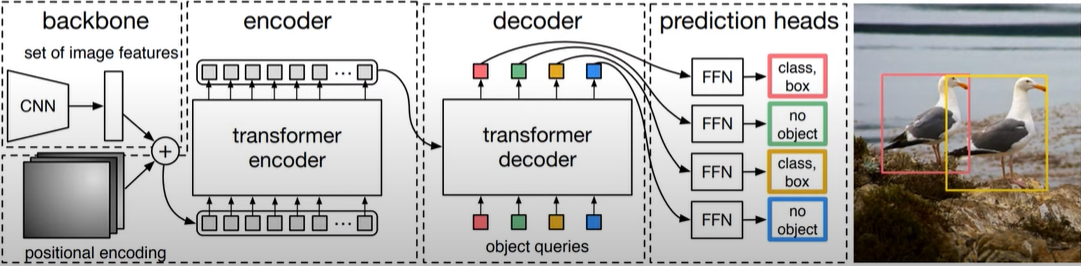

#### **`개괄적 파악`**

> backbone
    
    기본적으로 어떤 이미지에서 feature들을 추출하기 위한 목적으로 해당 네트워크가 사용
    추가적으로 이미지에서 각각의 상대적인 위치 정보를 담기 위해서 positional encoding을 통해 encoder로 data를 보냄 

> encoder

    각각의 픽셀 정보들은 일종의 순차적인 data로 분류가 되어 일련의 data를 처리하기에 적합한 transformer encoder로 삽입됨
    이때 각각의 data들은 특정 dimension을 가지는 이미지 feature로서 구성이 됨
    정리하자면, 각각의 픽셀이 가지고 있는 이미지 feature 정보들이 순차적으로 처리가 되어 encode가 여러 개의 layer를 거쳐 encoding을 수행하고 decoder 파트로 삽입됨
    
> decoder + prediction heads

    몇개의 query를 거쳐 나온 결과가 각각 object에 대한 class와 그 object가 어디 존재하는지 그 bounding box의 위치를 알려줄 수 있도록 분류됨.
    object가 존재하지 않다면 "no object"라고 class가 분류됨

- 이렇게 처음 이미지가 들어왔을 때 그 이미지에 대해서 feature를 추출한 다음에 transformer를 거쳐서 결과적으로 객체 탐지가 가능하게 하는 것이 DETR 모델임
- 이렇게 탐지한 객체 탐지 결과가 실제 값과 비교했을 때 매칭이 성공적으로 이루어질 수 있도록 이분매칭함수까지 사용을 하고 이러한 이분매칭함수를 통해서 중복되지 않은 instance를 각각 탐지할 수 있도록 만들어줌


---